In [151]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, MaxPooling2D, Embedding, Conv2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Data Preprocessing

### Load Dataset

In [135]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
        
        # Extract features and labels
        X = data[b'data']
        y = data[b'labels']
        
        # Reshape features to (number of samples, 32, 32, 3)
        X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return X, np.array(y)

In [136]:
X_data = []
y_data = []

In [137]:
for batch in range(1, 6):
    X_batch, y_batch = unpickle(f'./cifar-10-batches-py/data_batch_{batch}')
    X_data.append(X_batch)
    y_data.append(y_batch)

# Combine all batches into one dataset
X_data_full = np.concatenate(X_data)
y_data_full = np.concatenate(y_data)

### Splitting
Split the model into training (80%), testing (10%), and validation (10%)

In [138]:
# split into training and a temporary set called tv -> training is 80%
X_train, X_tv, y_train, y_tv = train_test_split(X_data_full, y_data_full, test_size=0.8)

# split the temporary set into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5)

### Visualizing Data

In [139]:
def visualize_cifar10_images(images, labels, class_names, num_images=10):
    """
    Visualizes a grid of CIFAR-10 images.

    Parameters:
    - images: The input array of images (e.g., (num_samples, 32, 32, 3))
    - labels: The array of corresponding labels
    - class_names: List of class names that correspond to the numerical labels
    - num_images: Number of images to display in the grid (must be a perfect square)
    """
    # Ensure the number of images is a perfect square for a square grid layout
    grid_size = int(np.sqrt(num_images))
    assert grid_size * grid_size == num_images, "Number of images should be a perfect square."

    # Create a plot with grid_size x grid_size subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle("CIFAR-10 Images", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Show the image on the subplot
            ax.imshow(images[i])
            # Set the title with the class name
            ax.set_title(class_names[labels[i]])
            ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [140]:
def load_cifar10_meta(meta_file):
    with open(meta_file, 'rb') as file:
        meta = pickle.load(file, encoding='bytes')
        class_names = [label.decode('utf-8') for label in meta[b'label_names']]
        return class_names


# Load the class names
class_names = load_cifar10_meta('./cifar-10-batches-py/batches.meta')

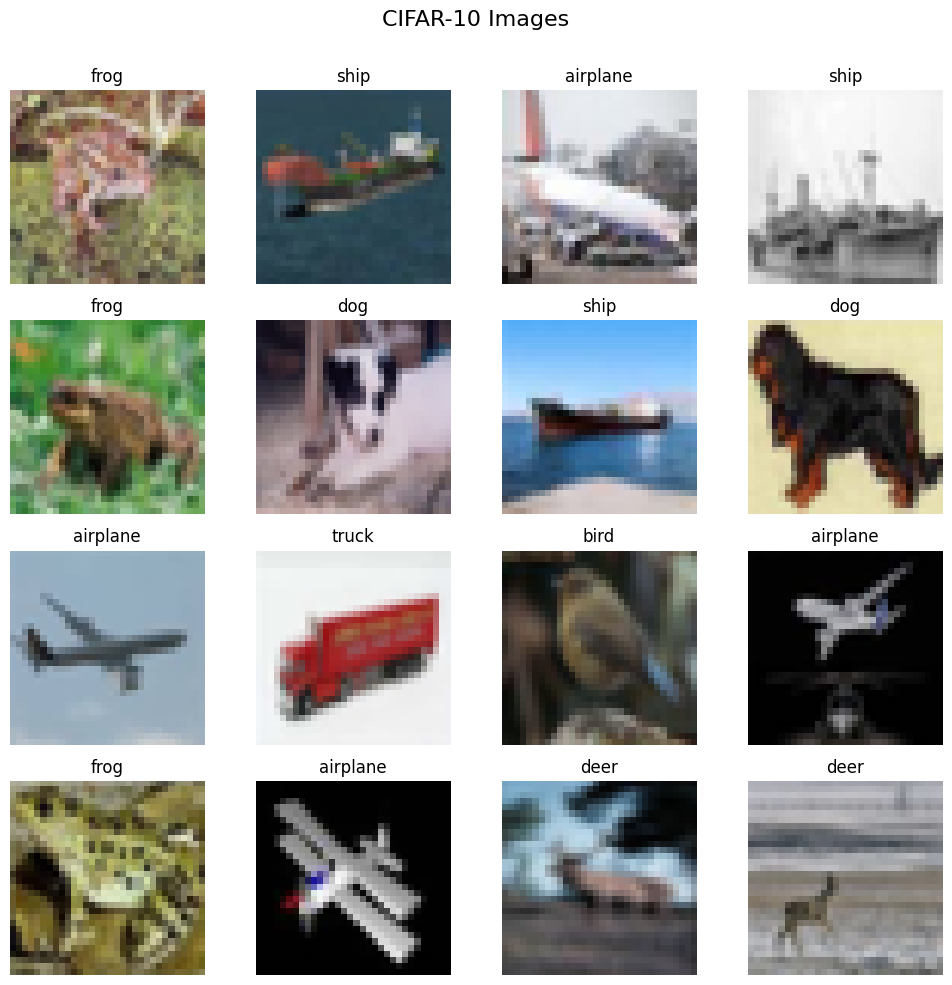

In [141]:
num_images_to_show = 16

visualize_cifar10_images(X_train[:num_images_to_show],y_train[:num_images_to_show], class_names, num_images=num_images_to_show)

### Augment and normalize pixel data

In [175]:
training_datagen = ImageDataGenerator(
    width_shift_range=0.1,  # Random horizontal shifts up to 10% of the width
    height_shift_range=0.1,  # Random vertical shifts up to 10% of the height
    horizontal_flip=True,    # Randomly flip the image horizontally
    rescale=1.0 / 255.0     # normalizez pixel data
)

training_datagen.fit(X_train)
train_generator = training_datagen.flow(X_train, y_train, batch_size=32)

In [176]:
test_val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# validation
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=32)

# test
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=32)

## Model Architecture

Helper Functions

In [152]:
def display_charts(history):
    # Plot training & validation loss values
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.show()

In [153]:
def display_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)


    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### CNN Model

In [156]:
cnn = Sequential()

# Layer 1: Convolutional with batch normalization and dropout
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
# Input: (32, 32, 3) - 32x32 RGB image
# Output: (32, 32, 32) - 32 filters, 32x32 size
# Parameters: (3 * 3 * 3 * 32) + 32 = 896

cnn.add(BatchNormalization())
# Input/Output: (32, 32, 32)
# Parameters: (32 * 2) = 64 (32 scale + 32 shift parameters)

cnn.add(MaxPooling2D((2, 2)))
# Input: (32, 32, 32)
# Output: (16, 16, 32) - after pooling down

cnn.add(Dropout(0.25))
# No change in dimensions, only regularizes the data

# Layer 2: Convolutional with batch normalization and dropout
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# Input: (16, 16, 32)
# Output: (14, 14, 64) - 64 filters
# Parameters: (3 * 3 * 32 * 64) + 64 = 18,496

cnn.add(BatchNormalization())
# Input/Output: (14, 14, 64)
# Parameters: (64 * 2) = 128 (64 scale + 64 shift)

cnn.add(MaxPooling2D((2, 2)))
# Input: (14, 14, 64)
# Output: (7, 7, 64) - after pooling down

cnn.add(Dropout(0.25))
# No change in dimensions, only regularizes the data

# Layer 3: Convolutional with batch normalization
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# Input: (7, 7, 64)
# Output: (5, 5, 128) - 128 filters
# Parameters: (3 * 3 * 64 * 128) + 128 = 73,856

cnn.add(BatchNormalization())
# Input/Output: (5, 5, 128)
# Parameters: (128 * 2) = 256 (128 scale + 128 shift)

cnn.add(MaxPooling2D((2, 2)))
# Input: (5, 5, 128)
# Output: (2, 2, 128) - after pooling down

cnn.add(Dropout(0.25))
# No change in dimensions, only regularizes the data

# Flatten the output and add fully connected layers with dropout
cnn.add(Flatten())
# Input: (2, 2, 128)
# Output: (2 * 2 * 128) = 512

cnn.add(Dense(512, activation='relu'))
# Input: 512
# Output: 512
# Parameters: (512 * 512) + 512 = 262,656

cnn.add(Dropout(0.5))
# No change in dimensions, only regularizes the data

# Output layer: 10 neurons for 10 classes
cnn.add(Dense(10, activation='softmax'))
# Input: 512
# Output: 10
# Parameters: (512 * 10) + 10 = 5,130

In [157]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_43 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_44 (Bat  (None, 16, 16, 64)     

In [158]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [159]:
# Train the model
history = cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


2024-05-05 18:03:51.147509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


313/313 [==============================] - ETA: 0s - loss: 2.6395 - accuracy: 0.2123

2024-05-05 18:04:00.188071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


313/313 [==============================] - 15s 43ms/step - loss: 2.6395 - accuracy: 0.2123 - val_loss: 4.0945 - val_accuracy: 0.1032
Epoch 2/50
313/313 [==============================] - 13s 43ms/step - loss: 1.9952 - accuracy: 0.2782 - val_loss: 2.0108 - val_accuracy: 0.3463
Epoch 3/50
313/313 [==============================] - 14s 44ms/step - loss: 1.8914 - accuracy: 0.3064 - val_loss: 1.7142 - val_accuracy: 0.4156
Epoch 4/50
313/313 [==============================] - 13s 42ms/step - loss: 1.8138 - accuracy: 0.3407 - val_loss: 1.5682 - val_accuracy: 0.4472
Epoch 5/50
313/313 [==============================] - 13s 41ms/step - loss: 1.7400 - accuracy: 0.3627 - val_loss: 1.5200 - val_accuracy: 0.4636
Epoch 6/50
313/313 [==============================] - 13s 41ms/step - loss: 1.6865 - accuracy: 0.3752 - val_loss: 1.4741 - val_accuracy: 0.4778
Epoch 7/50
313/313 [==============================] - 13s 42ms/step - loss: 1.6384 - accuracy: 0.4024 - val_loss: 1.4979 - val_accuracy: 0.4846
Epo

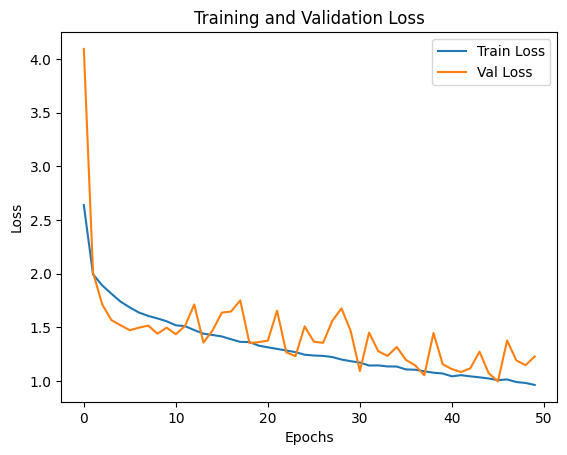

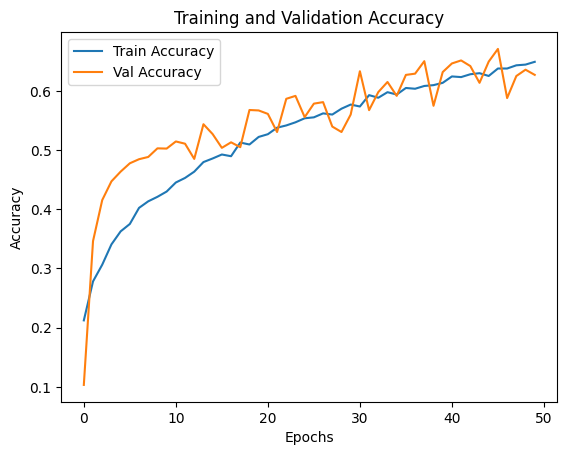

In [160]:
display_charts(history.history)

## Evaluate

In [185]:
# make prediction.
pred = cnn.predict(X_test)

625/625 [==============================] - 5s 8ms/step


In [186]:
y_pred = np.argmax(pred, axis=1)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.23      0.87      0.36      1969
  automobile       0.73      0.39      0.51      1966
        bird       1.00      0.00      0.00      2003
         cat       0.30      0.05      0.09      1998
        deer       0.00      0.00      0.00      2003
         dog       0.41      0.44      0.42      1926
        frog       0.72      0.14      0.24      2022
       horse       0.40      0.71      0.51      2026
        ship       0.63      0.51      0.57      2047
       truck       0.47      0.76      0.58      2040

    accuracy                           0.39     20000
   macro avg       0.49      0.39      0.33     20000
weighted avg       0.49      0.39      0.33     20000



/Users/sab0taj/opt/anaconda3/envs/fastml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sab0taj/opt/anaconda3/envs/fastml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sab0taj/opt/anaconda3/envs/fastml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

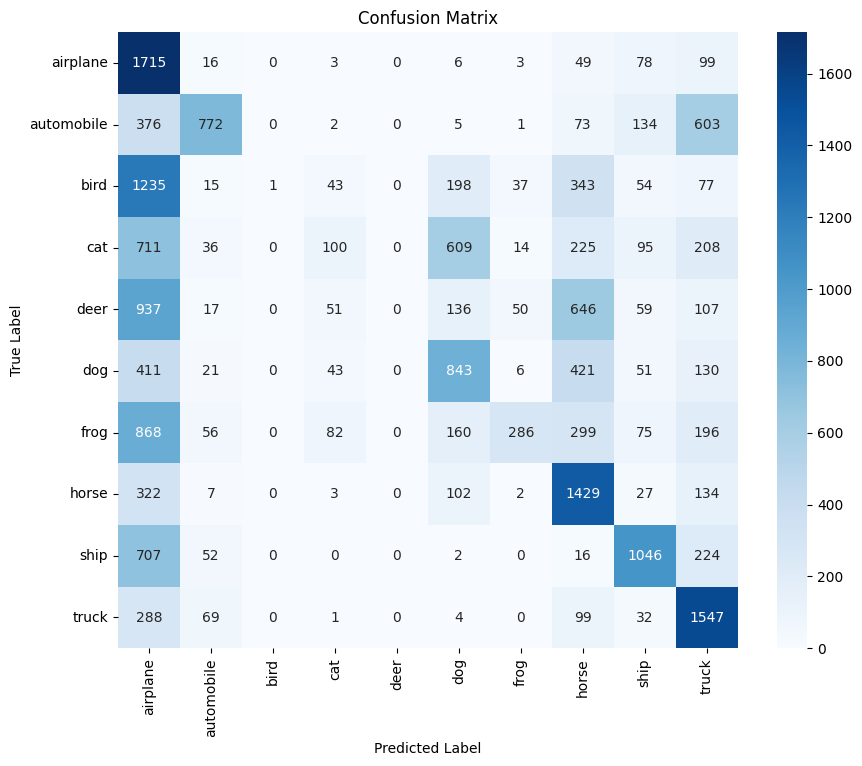

In [187]:
display_confusion_matrix(y_test, y_pred)

### Error Analysis

#### Common Misclassifications:
   - **Birds** are often mistaken for "airplane" or "automobile."
   - **Cats** are frequently confused with "dogs" or "frogs."
   - **Deers** are incorrectly classified as "airplane," "dog," and "truck."
   - **Dogs** are often classified as "cat" or "horse."

#### Recommendations for Improvement

1. **Increase Data Quality**:
   - Ensure that the classes are well represented in the training set.
   - Consider using data augmentation to balance class distribution.

2. **Model Architecture**:
   - Experiment with deeper models like ResNet or EfficientNet.
   - Add regularization techniques like dropout or weight decay.

3. **Hyperparameter Tuning**:
   - Experiment with different optimizers and learning rates.
   - Adjust batch sizes or epochs to prevent overfitting or underfitting.

4. **Error Analysis**:
   - Review specific misclassifications and see if the model is missing essential features.
   - Refine pre-processing techniques to help the model recognize specific features for underperforming classes.

## Testing

In [181]:
# Evaluate the model on the test set to obtain the final test accuracy
test_loss, test_accuracy = cnn.evaluate(test_generator, verbose=1)

# Report the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2024-05-05 19:10:47.855825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


625/625 [==============================] - 6s 9ms/step - loss: 1.2275 - accuracy: 0.6245
Test Loss: 1.2275
Test Accuracy: 62.45%


## Summary

#### Model Summary

The convolutional neural network (CNN) utilized to classify the CIFAR-10 dataset consisted of multiple convolutional layers, pooling layers, and fully connected layers. Key aspects of the model include:

- **Convolutional Layers**: These layers extract local spatial features from images. Our network included three convolutional layers with ReLU activation.
- **Pooling Layers**: These reduce the dimensionality while retaining important features, achieved through MaxPooling layers.
- **Regularization**:
  - **Batch Normalization**: Used to normalize feature maps and stabilize learning.
  - **Dropout**: Included to prevent overfitting by randomly disabling neurons.
- **Fully Connected Layers**: Two dense layers were used to learn global patterns across classes.

**Output Layer**: The final dense layer, activated by a softmax function, provided probability distributions across the ten CIFAR-10 classes.

#### Performance Analysis

1. **Overall Accuracy**: 
   - The final test accuracy was 39%, revealing significant opportunities for improvement in model performance.

2. **Precision, Recall, and F1-Score**:
   - **Precision**: With an average precision of 49%, the model performed well on some classes but poorly on others, particularly "deer."
   - **Recall**: Average recall was 39%, meaning that the model missed many instances of the target classes.
   - **F1-Score**: The harmonic mean of precision and recall was an average of 33%, further highlighting model struggles in generalization.

3. **Class-wise Analysis**:
   - **Airplane**: High recall (87%) and low precision (23%) suggest significant confusion between airplanes and other classes like "automobile" and "bird."
   - **Automobile**: Despite reasonable precision (73%), the model often misclassified true automobiles as other classes, possibly due to their similar appearance in different contexts.
   - **Bird**: High precision (100%) but zero recall indicates a misalignment between training and validation data.
   - **Deer**: The model was unable to classify deer properly, highlighting either a feature extraction limitation or a class imbalance problem.
   - **Truck**: Despite reasonable precision (47%) and recall (76%), confusion remains with classes like "ship."

4. **Confusion Matrix**:
   - The confusion matrix illustrates patterns of frequent misclassifications, particularly for birds, cats, and deer.

#### Recommendations for Improvement

1. **Model Complexity and Regularization**:
   - Consider using more sophisticated architectures like ResNet or EfficientNet, known for their improved feature extraction.
   - Apply stronger regularization to prevent overfitting.

2. **Data Augmentation and Preprocessing**:
   - Apply data augmentation techniques like rotations, flips, and color shifts to enhance dataset diversity.
   - Normalize images consistently to avoid discrepancies.

3. **Balanced Dataset**:
   - Address class imbalance by oversampling underrepresented classes or implementing class weights in the loss function.

4. **Hyperparameter Tuning**:
   - Tune learning rates, batch sizes, and optimizer parameters to ensure stable training.

5. **Early Stopping**:
   - Implement early stopping to prevent the model from overfitting to the training data.

### Conclusion
Despite achieving moderate results, our CNN model shows significant potential for improvement in both data quality and model architecture. By refining the training process and architecture, we can significantly enhance the model's ability to generalize across all classes in the CIFAR-10 dataset.